In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

In [2]:

RANDOM_STATE = 42
DATA_DIR = "./data"
EXERCISE_PATH = os.path.join(DATA_DIR, "exercise.csv")
CALORIES_PATH = os.path.join(DATA_DIR, "calories.csv")

print("Dataset Paths")
print("Exercise CSV path:", EXERCISE_PATH)
print("Calories CSV path:", CALORIES_PATH)

exercise = pd.read_csv(EXERCISE_PATH)
calories = pd.read_csv(CALORIES_PATH)

print("\nDataset Dimensions")
print("Exercise Shape:", exercise.shape)
print("Calories Shape:", calories.shape)

print("\n \nDataset First 5 rows!")
display(exercise.head())
display(calories.head())

Dataset Paths
Exercise CSV path: ./data/exercise.csv
Calories CSV path: ./data/calories.csv

Dataset Dimensions
Exercise Shape: (15000, 8)
Calories Shape: (15000, 2)

 
Dataset First 5 rows!


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [3]:
# Merge on User_ID
df = pd.merge(exercise, calories, on="User_ID", how="inner")
print("Merged shape:", df.shape)

# Clean column names
df.columns = [col.strip().replace(" ", "_") for col in df.columns]

# Key numeric columns
numeric_cols = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "Calories"]

for col in numeric_cols: df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing key info
df = df.dropna(subset=numeric_cols + ["Gender"]).reset_index(drop=True)

# Normalize gender text and encode: male -> 1, female -> 0
df["Gender"] = df["Gender"].str.lower().str.strip()
gender_map = {"male": 1, "female": 0}
df["Gender"] = df["Gender"].map(gender_map)

# BMI feature: kg / m^2
df["BMI"] = (df["Weight"] / ((df["Height"]/100) ** 2)).round(2)

# Final feature set and target
feature_cols = ["Gender", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "BMI"]
target_col = "Calories"

print("Final columns used for modeling:")
print("Features:", feature_cols)
print("Target  :", target_col)
display(df.head())

Merged shape: (15000, 9)
Final columns used for modeling:
Features: ['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']
Target  : Calories


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0,26.04
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0,21.77
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0,24.66
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0,22.16
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0,24.46


In [4]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
X = df[feature_cols].copy()
y = df[target_col].values

X_train_full, X_test, y_train_full, y_test, gender_train_full, gender_test, age_train_full, age_test = train_test_split(
    X,
    y,
    df["Gender"],
    df["Age"],
    test_size=0.2,
    random_state=RANDOM_STATE
)

X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [7]:
lasso_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.01, max_iter=10000))
])

lasso_poly.fit(X_train_full, y_train_full)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+04, tolerance: 4.639e+03
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, max_iter=10000))])

In [8]:
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [9]:
print("\n=== Poly LASSO(2): Hold-out performance ===")
y_pred_poly = lasso_poly.predict(X_test)
rmse, mae, r2 = regression_metrics(y_test, y_pred_poly)

rq2_poly_table = pd.DataFrame([{
    "Model": "LASSO + Poly(2)",
    "RMSE": rmse,
    "MAE": mae,
    "R^2": r2
}])

rq2_poly_table_fmt = rq2_poly_table.copy()
for col in ["RMSE", "MAE", "R^2"]:
    rq2_poly_table_fmt[col] = rq2_poly_table_fmt[col].map(lambda v: f"{v:.3f}")

display(rq2_poly_table_fmt)


=== Poly LASSO(2): Hold-out performance ===


,Model,RMSE,MAE,R^2
0,LASSO + Poly(2),3.113,2.326,0.998


## PDP & ICE For Poly LASSO

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [10]:
# Monotonic constraints: Duration and Heart_Rate must be non-decreasing
# feature_cols = ["Gender_Code", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "BMI"]
monotonic_cst = [0, 0, 0, 0, 1, 1, 0, 0]

gbdt_mono = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=5,
    learning_rate=0.05,
    max_iter=500,
    monotonic_cst=monotonic_cst,
    random_state=42,
)

In [11]:
lasso_poly.fit(X_train, y_train)
gbdt_mono.fit(X_train, y_train)

def report(name, yt, yp):
    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    r2 = r2_score(yt, yp)
    print(f"{name} RMSE={rmse:.4f} | R²={r2:.4f}")

pred_lasso_poly = lasso_poly.predict(X_test)
pred_gbdt = gbdt_mono.predict(X_test)

report("LASSO + Poly(2)", y_test, pred_lasso_poly)
report("Monotone GBDT", y_test, pred_gbdt)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+04, tolerance: 3.495e+03
  model = cd_fast.enet_coordinate_descent(


LASSO + Poly(2) RMSE=3.1207 | R²=0.9976
Monotone GBDT RMSE=2.3794 | R²=0.9986


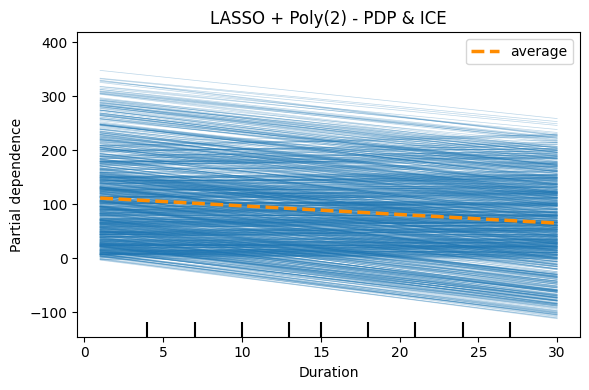

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

PartialDependenceDisplay.from_estimator(
    lasso_poly,
    X_train,
    ["Duration"],
    kind="both",
    grid_resolution=60,
    ax=ax,
    ice_lines_kw={"alpha": 0.3, "linewidth": 0.5},
    pd_line_kw={"color": "darkorange", "linewidth": 2.5},
)

ax.set_title("LASSO + Poly(2) - PDP & ICE")

plt.tight_layout()
plt.show()

# R-Square Overfitting - Polynomial LASSO

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

pred_poly = lasso_poly.predict(X_test)

rmse_poly = np.sqrt(mean_squared_error(y_test, pred_poly))
r2_poly = r2_score(y_test, pred_poly)

print(f"LASSO + Poly(2)  Test RMSE={rmse_poly:.4f} | R²={r2_poly:.4f}")

LASSO + Poly(2)  Test RMSE=2.7886 | R²=0.9981


In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def print_test_metrics(name, model, X_test, y_test):
    pred = model.predict(X_test)
    print(f"{name} -> Test RMSE = {rmse(y_test, pred):.4f}")

#### A) Learning curves (Train vs Validation RMSE)

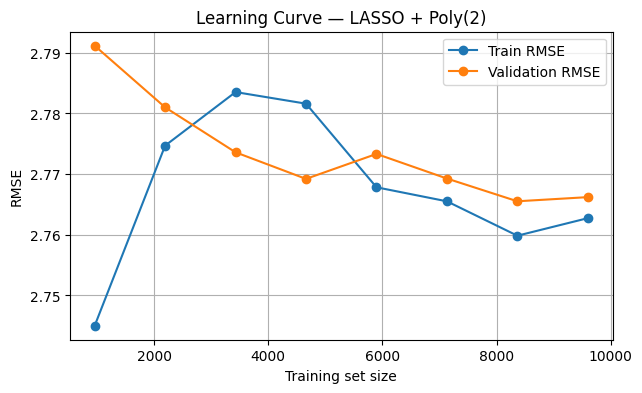

,train_size,train_rmse,val_rmse,gap(val-train)
0,960,2.745013,2.791172,0.046159
1,2194,2.774701,2.781012,0.006312
2,3428,2.783532,2.773602,-0.009930
3,4662,2.781620,2.769219,-0.012401
4,5897,2.767834,2.773334,0.005501
5,7131,2.765521,2.769275,0.003754
6,8365,2.759853,2.765528,0.005675
7,9600,2.762748,2.766212,0.003464


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, ShuffleSplit

def plot_learning_curve_rmse(model, X, y, title):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1,
        shuffle=True,
        random_state=42,
    )

    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)

    plt.figure(figsize=(7,4))
    plt.plot(train_sizes, train_rmse, marker="o", label="Train RMSE")
    plt.plot(train_sizes, val_rmse, marker="o", label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.legend()
    plt.show()

    out = pd.DataFrame({
        "train_size": train_sizes,
        "train_rmse": train_rmse,
        "val_rmse": val_rmse,
        "gap(val-train)": val_rmse - train_rmse
    })
    display(out)

plot_learning_curve_rmse(lasso_poly, X_train, y_train, "Learning Curve — LASSO + Poly(2)")

#### B) Permutation test (shuffle Duration / Heart_Rate and measure RMSE + R² drop)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def permutation_feature_test(model, X_test, y_test, feature, repeats=10, seed=42):
    rng = np.random.default_rng(seed)

    base_pred = model.predict(X_test)
    base_rmse = rmse(y_test, base_pred)
    base_r2 = r2_score(y_test, base_pred)

    rmses, r2s = [], []
    for _ in range(repeats):
        Xp = X_test.copy()
        Xp[feature] = rng.permutation(Xp[feature].values)

        # Keep derived feature consistent if present
        if "Training_Load" in Xp.columns:
            Xp["Training_Load"] = Xp["Heart_Rate"] * Xp["Duration"]

        pred = model.predict(Xp)
        rmses.append(rmse(y_test, pred))
        r2s.append(r2_score(y_test, pred))

    return {
        "feature": feature,
        "base_rmse": float(base_rmse),
        "perm_rmse_mean": float(np.mean(rmses)),
        "rmse_increase": float(np.mean(rmses) - base_rmse),
        "base_r2": float(base_r2),
        "perm_r2_mean": float(np.mean(r2s)),
        "r2_drop": float(base_r2 - np.mean(r2s)),
    }

rows = []
for f in ["Duration", "Heart_Rate"]:
    rows.append(permutation_feature_test(lasso_poly, X_test, y_test, f, repeats=10))

pd.DataFrame(rows)

,feature,base_rmse,perm_rmse_mean,rmse_increase,base_r2,perm_r2_mean,r2_drop
0,Duration,2.78859,65.130713,62.342123,0.998073,-0.051255,1.049329
1,Heart_Rate,2.78859,31.804811,29.016221,0.998073,0.749306,0.248767


# R-Square Overfitting - Monotone GBDT

#### A) Learning Curves — Monotone GBDT

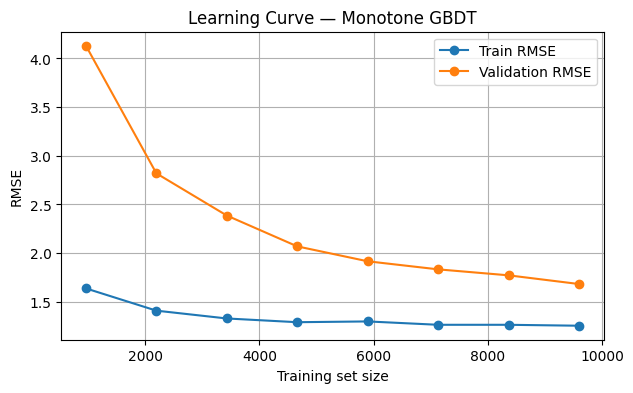

,train_size,train_rmse,val_rmse,gap(val-train)
0,960,1.637566,4.130415,2.492850
1,2194,1.409126,2.819357,1.410231
2,3428,1.328837,2.386075,1.057238
3,4662,1.290506,2.069356,0.778850
4,5897,1.298409,1.916068,0.617659
5,7131,1.263901,1.833230,0.569330
6,8365,1.263862,1.771918,0.508057
7,9600,1.254355,1.682441,0.428085


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, ShuffleSplit

def plot_learning_curve_rmse(model, X, y, title):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1,
        shuffle=True,
        random_state=42,
    )

    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)

    plt.figure(figsize=(7,4))
    plt.plot(train_sizes, train_rmse, marker="o", label="Train RMSE")
    plt.plot(train_sizes, val_rmse, marker="o", label="Validation RMSE")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

    out = pd.DataFrame({
        "train_size": train_sizes,
        "train_rmse": train_rmse,
        "val_rmse": val_rmse,
        "gap(val-train)": val_rmse - train_rmse
    })
    display(out)

plot_learning_curve_rmse(
    gbdt_mono,
    X_train,
    y_train,
    "Learning Curve — Monotone GBDT"
)

#### B) Permutation Test — Monotone GBDT

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def permutation_feature_test(model, X_test, y_test, feature, repeats=10, seed=42):
    rng = np.random.default_rng(seed)

    base_pred = model.predict(X_test)
    base_rmse = rmse(y_test, base_pred)
    base_r2 = r2_score(y_test, base_pred)

    rmses, r2s = [], []
    for _ in range(repeats):
        Xp = X_test.copy()
        Xp[feature] = rng.permutation(Xp[feature].values)

        if "Training_Load" in Xp.columns:
            Xp["Training_Load"] = Xp["Heart_Rate"] * Xp["Duration"]

        pred = model.predict(Xp)
        rmses.append(rmse(y_test, pred))
        r2s.append(r2_score(y_test, pred))

    return {
        "feature": feature,
        "base_rmse": float(base_rmse),
        "perm_rmse_mean": float(np.mean(rmses)),
        "rmse_increase": float(np.mean(rmses) - base_rmse),
        "base_r2": float(base_r2),
        "perm_r2_mean": float(np.mean(r2s)),
        "r2_drop": float(base_r2 - np.mean(r2s)),
    }

rows = []
for f in ["Duration", "Heart_Rate"]:
    rows.append(permutation_feature_test(gbdt_mono, X_test, y_test, f, repeats=10))

pd.DataFrame(rows)

,feature,base_rmse,perm_rmse_mean,rmse_increase,base_r2,perm_r2_mean,r2_drop
0,Duration,1.627333,65.068388,63.441055,0.999344,-0.049240,1.048584
1,Heart_Rate,1.627333,30.033100,28.405767,0.999344,0.776469,0.222874


## R-Square Overfitting - LASSO


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

lasso_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.01, max_iter=10000))
])

lasso_linear.fit(X_train, y_train)


#### A) Learning Curves — LASSO Linear

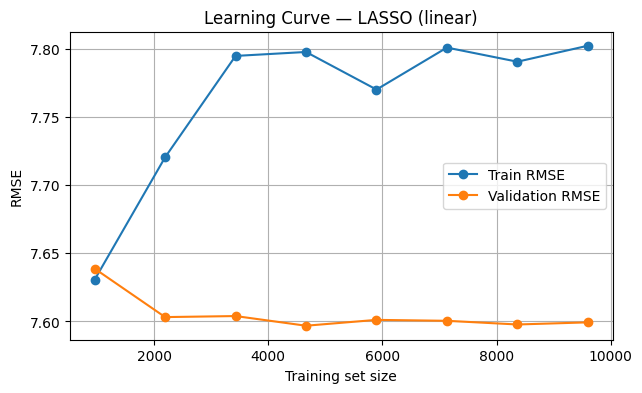

,train_size,train_rmse,val_rmse,gap(val-train)
0,960,7.630672,7.638707,0.008035
1,2194,7.720428,7.603186,-0.117242
2,3428,7.794764,7.603944,-0.190819
3,4662,7.797658,7.596857,-0.200800
4,5897,7.770086,7.601146,-0.168939
5,7131,7.800877,7.600462,-0.200415
6,8365,7.790513,7.597767,-0.192747
7,9600,7.802242,7.599326,-0.202916


In [ ]:

from sklearn.model_selection import learning_curve, ShuffleSplit

def plot_learning_curve_rmse(model, X, y, title):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1,
        shuffle=True,
        random_state=42,
    )

    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)

    plt.figure(figsize=(7,4))
    plt.plot(train_sizes, train_rmse, marker="o", label="Train RMSE")
    plt.plot(train_sizes, val_rmse, marker="o", label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.legend()
    plt.show()

    out = pd.DataFrame({
        "train_size": train_sizes,
        "train_rmse": train_rmse,
        "val_rmse": val_rmse,
        "gap(val-train)": val_rmse - train_rmse
    })
    display(out)

plot_learning_curve_rmse(lasso_linear, X_train, y_train, "Learning Curve — LASSO (linear)")

#### B) Permutation Test — LASSO Linear


In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def permutation_feature_test(model, X_test, y_test, feature, repeats=10, seed=42):
    rng = np.random.default_rng(seed)

    base_pred = model.predict(X_test)
    base_rmse = rmse(y_test, base_pred)
    base_r2 = r2_score(y_test, base_pred)

    rmses, r2s = [], []
    for _ in range(repeats):
        Xp = X_test.copy()
        Xp[feature] = rng.permutation(Xp[feature].values)

        pred = model.predict(Xp)
        rmses.append(rmse(y_test, pred))
        r2s.append(r2_score(y_test, pred))

    return {
        "feature": feature,
        "base_rmse": float(base_rmse),
        "perm_rmse_mean": float(np.mean(rmses)),
        "rmse_increase": float(np.mean(rmses) - base_rmse),
        "base_r2": float(base_r2),
        "perm_r2_mean": float(np.mean(r2s)),
        "r2_drop": float(base_r2 - np.mean(r2s)),
    }

rows = []
for f in ["Duration", "Heart_Rate"]:
    rows.append(permutation_feature_test(lasso_linear, X_test, y_test, f, repeats=10))

pd.DataFrame(rows)

,feature,base_rmse,perm_rmse_mean,rmse_increase,base_r2,perm_r2_mean,r2_drop
0,Duration,7.916542,80.768175,72.851633,0.984471,-0.616534,1.601005
1,Heart_Rate,7.916542,7.944718,0.028176,0.984471,0.984360,0.000111
